# Exercise: putting everything together


In this you will write code for a model that learns to classify mnist digits. You will use sonnet and tensorflow, tracking training progress with matplotlib.

In [1]:
#@title Install
# Install dm-sonnet with pip.
!pip install dm-sonnet

In [0]:
#@title Import
# Include all necessary imports.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sonnet as snt

from matplotlib import pyplot as plt

## Fetch Data

In [0]:
tf.reset_default_graph()

In [3]:
# Fetch the mnist data from tf.keras.datasets.mnist.

mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

# Check what the data is like:
print('Training dataset:')
train_input, train_label = mnist_train
print('* input shape:', train_input.shape)
print('* input min, mean, max:', train_input.min(), train_input.mean(), train_input.max())
print('* input dtype:', train_input.dtype)
print('* label shape:', train_label.shape)
print('* label min, mean, max:', train_label.min(), train_label.mean(), train_label.max())
print('* label dtype:', train_label.dtype)

test_input, test_label = mnist_test
print('Number of test examples:', test_input.shape[0])

Training dataset:
* input shape: (60000, 28, 28)
* input min, mean, max: 0 33.318421449829934 255
* input dtype: uint8
* label shape: (60000,)
* label min, mean, max: 0 4.4539333333333335 9
* label dtype: uint8
Number of test examples: 10000


Normalize the data into the \[0, 1\] interval. It's also a good idea to check the class distribution, but here we know that this is OK.



## Normalize Data

In [0]:
# Normalize both train_input and test_input so that it is in [0, 1].
#
# Also ensure the following data types:
#
# * train_input and test_input need to be np.float32.
# * the labels need to be converted to np.int32.

In [0]:
#@title Before normalization
print(train_input.dtype, np.min(train_input), np.max(train_input))
print(test_input.dtype, np.min(test_input), np.max(test_input))

print(train_label.dtype, test_label.dtype)

uint8 0 255
uint8 0 255
uint8 uint8


In [0]:
#@title Solution

train_input = ((train_input - np.min(train_input)) / np.max(train_input))
test_input = ((test_input - np.min(test_input)) / np.max(test_input))

train_input = train_input.astype(np.float32)
test_input = test_input.astype(np.float32)
train_label = train_label.astype(np.int32)
test_label = test_label.astype(np.int32)

In [0]:
#@title After normalization
print(train_input.dtype, np.min(train_input), np.max(train_input))
print(test_input.dtype, np.min(test_input), np.max(test_input))

print(train_label.dtype, test_label.dtype)

float32 0.0 1.0
float32 0.0 1.0
int32 int32


In [0]:
#@title Gallery Function
# We can visualize the first few training examples using matplotlib.imshow()
# in combination with the gallery function we defined.
#
# Copy the gallery function in this cell.

def gallery(array, ncols=10, rescale=True):
  """Take a batch of images and arrange them in a grid.
  
  Args:
    array: of shape batch_size x height x width x 3. The final x3 in the shape
      is optional.
    ncols: number of columns to have in the grid
    rescale: if true (default), increases the intensity of the images.
    
  Returns:
    A numpy array which contains the batch of images arranged into
    a grid.
  """
  if rescale:
    array = (array + 1.) / 2
  nindex, height, width = array.shape[:3]

  nrows = nindex//ncols
  assert nindex == nrows*ncols

  # want result.shape = (height*nrows, width*ncols, intensity?)
  abstract_grid_shape = [nrows, ncols, height, width]
  image_grid_shape = [height*nrows, width*ncols]
  if len(array.shape) == 4:
    intensity = array.shape[3]
    abstract_grid_shape.append(intensity)
    image_grid_shape.append(intensity)
 
  result = (array.reshape(*abstract_grid_shape)
            .swapaxes(1,2)
            .reshape(*image_grid_shape))
  return result


## Plot sample data

In [0]:
# Show the first 6 training images on a 1x6 grid using the galerry function.
# Remember to use grayscale plotting.
# Also print their corresponding labels in the same order.

(6, 28, 28)


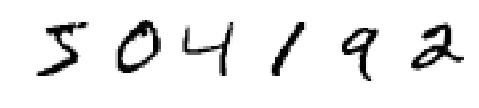

[5 0 4 1 9 2]


In [0]:
#@title Solution
print(train_input[:6].shape)

plt.figure()
plt.axis('off')
plt.imshow(gallery(train_input[:6], ncols=6, rescale=False))
plt.show()

print(train_label[:6])

## Get TF Dataset

In [0]:
# Write a function that turns the data into tensorflow datasets and into
# tensors corresponding to batches of examples, returning these tensors.
#
# The train data should be
#
# * shuffled across the full dataset
# * repeated indefinitely
# * batched at size 64.
#
# Simply batch the test data.
#
# IMPORTANT: Add a final (singleton) axis to the inputs; the conv nets that
# we will use will expect this.
# * HINT: recall the `np.newaxis` from Intro_Numpy.ipynb

In [0]:
#@title Solution

BATCH_SIZE = 64

def get_tf_data():
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (train_input[:, :, :, np.newaxis], train_label))
    train_dataset = train_dataset.shuffle(
        train_label.shape[0]).repeat().batch(BATCH_SIZE)
    train_dataset = train_dataset.make_one_shot_iterator().get_next()

    test_dataset = tf.data.Dataset.from_tensor_slices(
        (test_input[:, :, :, np.newaxis], test_label))
    test_dataset = test_dataset.batch(BATCH_SIZE)
    test_dataset = test_dataset.make_one_shot_iterator().get_next()
    
    return train_dataset, test_dataset

In [0]:
train_dataset, test_dataset = get_tf_data()

In [0]:
print(train_dataset[0])
print(train_dataset[1])
print(test_dataset[0])
print(test_dataset[1])

Tensor("IteratorGetNext:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("IteratorGetNext:1", shape=(?,), dtype=int32)
Tensor("IteratorGetNext_1:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("IteratorGetNext_1:1", shape=(?,), dtype=int32)


## Sonnet module

### Define your network as a Sonnet module

In [0]:
# Make a sonnet module that has the following structure:
#
# 1. sonnet Conv2D with 16 channes, kernel shape 3, stride 1, padding 'SAME'
# 2. max pooling with window_shape [3, 3], srides [2, 2], padding 'SAME'
# 3. ReLU
# 4. sonnet Conv2D with 16 channes, kernel shape 3, stride 1, padding 'SAME'
# 5. Flatten the final conv features using snt.BatchFlatten
# 6. A (dense) Linear layer with output_size = 10, the number of classes.
#
# You can write the sonnet module yourself, or use the helper module
# snt.Sequential([..layers..to..connect..]).

In [0]:
#@title Solution

class MyOwnNet(snt.AbstractModule):

  def __init__(self, output_size,
               name="moja_siet"):
    super(MyOwnNet, self).__init__(name=name)
    self._output_size = output_size
   
  def _build(self, inputs):
    # Inputs has shape batch_size x ?.inputs
    # 1
    latent = snt.Conv2D(output_channels=16, kernel_shape=3,
                        stride=1, padding='SAME')(inputs)
    # 2
    latent = tf.nn.max_pool(latent, [1, 3, 3, 1], [1, 2, 2, 1], 'SAME')
    # 3
    latent = tf.nn.relu(latent)
    # 4 
    latent = snt.Conv2D(output_channels=16, kernel_shape=3,
                        stride=1, padding='SAME')(latent)
    # 5
    flattened = snt.BatchFlatten()(latent)
    # 6
    output = snt.Linear(output_size=self._output_size)(flattened)
    
    return output

### Prepare data for training

In [0]:
tf.reset_default_graph()
(train_inputs, train_labels), (test_inputs, test_labels) = get_tf_data()

train_inputs, train_labels, test_inputs, test_labels

(<tf.Tensor 'IteratorGetNext:0' shape=(?, 28, 28, 1) dtype=float32>,
 <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=int32>,
 <tf.Tensor 'IteratorGetNext_1:0' shape=(?, 28, 28, 1) dtype=float32>,
 <tf.Tensor 'IteratorGetNext_1:1' shape=(?,) dtype=int32>)

## Prepare model for training

In [0]:
# 1. Instantiate a model
# 2. Hook it up to the training data,
# 3. Use the `tf.nn.sparse_softmax_cross_entropy_with_logits` op to define the loss
# 4. Define the train_op that minimizes the loss (averaged over the batch)
#    using the `GradientDescentOptimizer`. Set the learning rate to 0.01.
# 5. Get the initialization op.

In [0]:
#@title Solution

myownnet = MyOwnNet(output_size=10)
train_outputs = myownnet(train_inputs) # notice the easy re-use of TF graph
test_outputs = myownnet(test_inputs) # notice the easy re-use of TF graph
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=train_labels, logits=train_outputs))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(loss)
init_op = tf.global_variables_initializer()

In [0]:
# Write a function that takes a list of losses and plots them.

def plot_losses(losses):
    plt.figure()
    plt.title('Losses')
    plt.plot(losses, c='b')
    plt.show()

## Train the model

In [0]:
# Run the training loop, keeping track of losses and potentially the accuracy
# on the training set. Plot the loss curve intermittently.
#
# The simplest solution would add a new plot with each plotting call. You
# can play with the frequency of plotting (and recording) a bit in order
# to find something that works.
#
# Based on the loss curves, decide how to set your total number of training
# iterations. Once you are satified, add some code that evaluates your
# prediction accuracy (not loss!) on the test set.
#
# Note that the outputs from the network are logits; for prediction accuracy
# we can pick the most likely label and see if it is correct.

# The accuracy you should expect:
#
# * Roughly 90% after 1000 training steps.
# * 97-98% after 10k training steps.
#
# First iterate with 1k steps, if that works, train for 10k. 10k steps will
# be roughly 6 minutes on CPU.

Epoch #1 passed (937 training steps)...
Epoch #2 passed (1874 training steps)...
Epoch #3 passed (2811 training steps)...


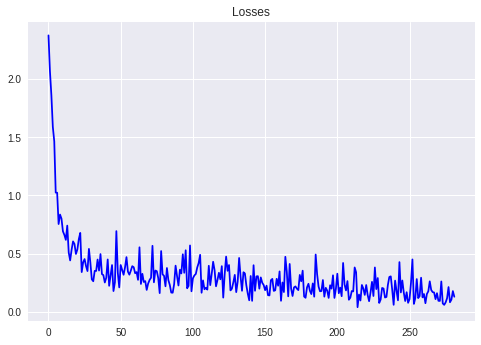

In [0]:
#@title Solution - minimal
EPOCHS = 3
STEPS = int(train_label.shape[0] / BATCH_SIZE)
RECORD_PERIOD = 10

with tf.Session() as sess:
    losses = []
    
    sess.run(init_op)
    for ep in range(EPOCHS):    
        for train_iter in range(STEPS):
            _, l = sess.run([train_op, loss])
            if (train_iter % RECORD_PERIOD) == 0:
                losses.append(l)
        print('Epoch #{} passed ({} training steps)...'.format(
            ep+1, (ep+1)*STEPS))
        
    plot_losses(losses)

After training step 0, accuracy on training set: 0.057291666666666664
After training step 1000, accuracy on training set: 0.9083333333333333
After training step 2000, accuracy on training set: 0.9260416666666667
After training step 3000, accuracy on training set: 0.959375
After training step 4000, accuracy on training set: 0.965625
After training step 5000, accuracy on training set: 0.96875
After training step 6000, accuracy on training set: 0.9546875
After training step 7000, accuracy on training set: 0.9697916666666667
After training step 8000, accuracy on training set: 0.9713541666666666
After training step 9000, accuracy on training set: 0.9802083333333333


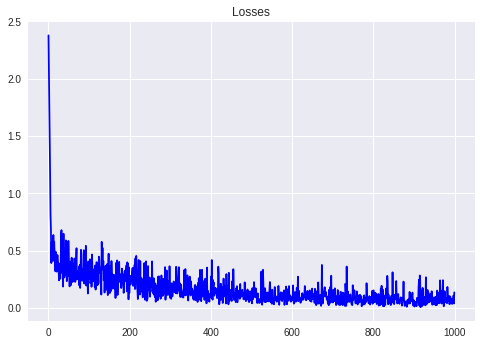

* Train: 0.9786458333333333
* Test: 0.9767


In [0]:
#@title Solution - full (with accuracy evaluation)

TRAIN_ITERS = int(10000)
RECORD_PERIOD = 10
PLOT_PERIOD = int(1000)


def get_accuracy(predictions, true_labels):
  assert predictions.shape == true_labels.shape  
  num_elements = predictions.shape[0]
  num_correct = np.count_nonzero(np.isclose(predictions, true_labels))
  return num_correct / num_elements
  

def get_predictions_and_true_labels(
    session, outputs_tensor, labels_tensor, num_batches=-1):
  all_predictions = []
  all_true_labels = []
  while num_batches != 0:
    try:
      outputs_np, labels_np = session.run([outputs_tensor, labels_tensor])
      if num_batches > 0:
        num_batches -= 1

      assert len(outputs_np.shape) == 2
      predictions = outputs_np.argmax(axis=1)
      all_predictions.append(predictions)
      all_true_labels.append(labels_np)
    except tf.errors.OutOfRangeError:
      break
      
  # Concatenate all collected data.
  return (
      np.concatenate(all_predictions),
      np.concatenate(all_true_labels),      
  )



losses = []
with tf.Session() as session:
    session.run(init_op)

    for train_iter in range(TRAIN_ITERS):
        _, loss_np = session.run([train_op, loss])

        if (train_iter % RECORD_PERIOD) == 0:
            losses.append(loss_np)

        if (train_iter % PLOT_PERIOD) == 0:
            #plot_losses(losses)
            predictions, true_labels = get_predictions_and_true_labels(
              session, train_outputs, train_labels, num_batches=30)
            print('After training step {}, accuracy on training set: {}'.format(
                train_iter, get_accuracy(predictions, true_labels)))
  
    plot_losses(losses)
    print('* Train:', get_accuracy(
      *get_predictions_and_true_labels(
          session, train_outputs, train_labels, num_batches=30)
    ))
    print('* Test:', get_accuracy(
      *get_predictions_and_true_labels(
          session, test_outputs, test_labels, num_batches=-1)
    ))

# Bonus: Solve the assignment using Keras

* Build and train the model using [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) API
* Refer to the [TensorFlow Keras documentation](https://www.tensorflow.org/guide/keras) but feel free to use official [Keras docs](https://keras.io/) for usage examples as well
* Prefer [Functional API](https://www.tensorflow.org/guide/keras#functional_api) over [Sequential](https://www.tensorflow.org/guide/keras#sequential_model) one, as it is much more flexible in how the model architecture can be designed (Sequential API is meant for simple architectures comprising of single sequence of layers)
* See [how `tf.keras` plugs with `tf.data`](https://www.tensorflow.org/guide/keras#input_tfdata_datasets)


In [0]:
from tensorflow.keras.layers import (Input, Reshape, Conv2D, MaxPooling2D,
                                     Flatten, Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

tf.reset_default_graph()

## Define the model

* use `tf.keras` Functional API to define the same model architecture as previously using Sonnet
* to compile the model you will need to choose:

    1) _optimizer_ to be used by Keras' training routines;

    2) _loss_ function to be minimized by _optimizer_;
    
    3) _metrics_ to be calculated by Keras' evaulation routines.
    
* To conform with the Sonnet example, start off using `tf.train.GradientDescentOptimizer`
    * you can always experiment later by switching to some Keras' optimizer, e.g. `SGD` or `Adam`.
* Use `categorical_crossentropy` loss function
* Use `accuracy` metric

In [0]:
#@title Solution

class ConvNet(object):
    def __init__(self, img_rows, img_cols, n_classes, optimizer=SGD,
                 loss='categorical_crossentropy',
                 metrics=['acc'], learning_rate=0.01):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.n_classes = n_classes

        self.optimizer = optimizer(learning_rate)
        self.loss = loss
        self.metrics = metrics

        self.model = None

    def build_model(self):
        input_layer = Input(shape=(self.img_rows, self.img_cols))

        # add channel dimension (required by conv layers)
        if tf.keras.backend.image_data_format() == 'channels_last':
            latent = Reshape((self.img_rows, self.img_cols, 1))(input_layer)
        else:
            latent = Reshape((1, self.img_rows, self.img_cols))(input_layer)

        # define the network architecture
        latent = Conv2D(filters=16, kernel_size=(3, 3), strides=1,
                        padding='same', activation='relu')(latent)
        latent = MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                              padding='same')(latent)
        latent = Conv2D(filters=16, kernel_size=(3, 3), strides=1,
                        padding='same', activation='linear')(latent)
        latent = Flatten()(latent)
        output_layer = Dense(units=self.n_classes, activation='softmax')(latent)

        self.model = Model(inputs=input_layer, outputs=output_layer)

        self.model.compile(optimizer=self.optimizer, loss=self.loss,
                           metrics=self.metrics)

#cnn = ConvNet(28, 28, 10)
cnn = ConvNet(28, 28, 10, optimizer=tf.train.GradientDescentOptimizer)
cnn.build_model()

## Train and Evaluate

* Try out Keras' `model.summary()` routine for text summarization of your Keras model.
* Try out Keras' `utils.plot_model()` routine for visual summarization of your Keras model.
* Make use of `tf.keras.utils.to_categorical()` routine to easily cast class labels to one-hot encodings.
* Try out `model.fit()` for training your Keras model.
* Try out `model.evaluate()` for final evaluation of your Keras model on test data.
* When training and evaluating your model, there are basically 2 options for providing inputs and labels to your model:
    * Use `numpy` arrays to provide inputs and labels to the model.
    * Alternatively, use `tf.data.Dataset` objects to provide inputs and labels to the model.

In [0]:
cnn.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                31370     
Total para

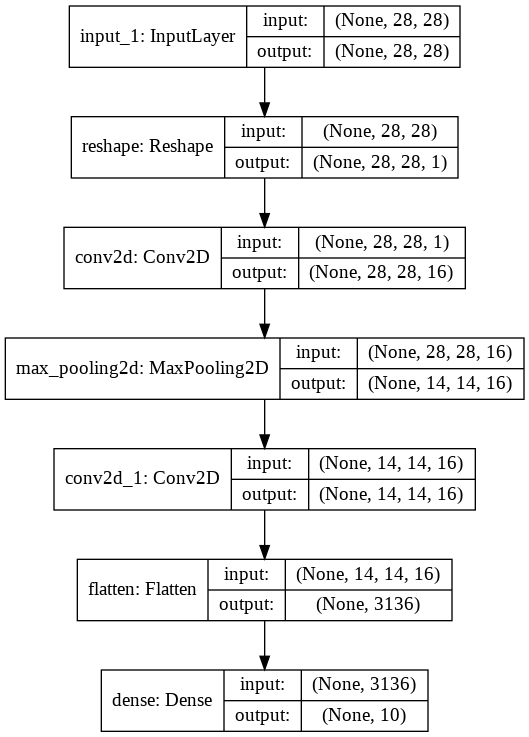

In [0]:
from IPython.display import Image

tf.keras.utils.plot_model(
    cnn.model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [0]:
EPOCHS = 10
BATCH_SIZE = 64

### Inputting `numpy` arrays

In [8]:
train_label_cat = tf.keras.utils.to_categorical(train_label, 10)
test_label_cat = tf.keras.utils.to_categorical(test_label, 10)
print(train_input.shape, test_input.shape)
print(train_label_cat.shape, test_label_cat.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 10) (10000, 10)


In [9]:
cnn.model.fit(train_input, train_label_cat,
              validation_data=(test_input, test_label_cat),
              batch_size=BATCH_SIZE, epochs=EPOCHS)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.5469 - acc: 0.8398 - val_loss: 0.3481 - val_acc: 0.8927
Epoch 2/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.3316 - acc: 0.9008 - val_loss: 0.2929 - val_acc: 0.9170
Epoch 3/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.2957 - acc: 0.9122 - val_loss: 0.2658 - val_acc: 0.9205
Epoch 4/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.2574 - acc: 0.9251 - val_loss: 0.2249 - val_acc: 0.9349
Epoch 5/10
60000/60000 [==============================] - 5s 78us/step - loss: 0.2050 - acc: 0.9408 - val_loss: 0.1639 - val_acc: 0.9519
Epoch 6/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.1548 - acc: 0.9557 - val_loss: 0.1254 - val_acc: 0.9627
Epoch 7/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.1213 - acc: 0.9648 - val_loss: 0.1016 - val_ac

In [10]:
score = cnn.model.evaluate(test_input, test_label_cat)
print('accuracy: {:.2f}% | loss: {}'.format(100*score[1], score[0]))

10000/10000 [==============================] - 1s 64us/step
accuracy: 97.88% | loss: 0.06739836002606898


### Inputting `tf.data.Dataset`

In [0]:
# Get new model instance --> compare results
cnn = ConvNet(28, 28, 10, optimizer=tf.train.GradientDescentOptimizer)
cnn.build_model()

In [12]:
BATCH_SIZE = 64

def get_tf_data():
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (train_input, train_label_cat))
    train_dataset = train_dataset.shuffle(
        train_label.shape[0]).batch(BATCH_SIZE).repeat()

    test_dataset = tf.data.Dataset.from_tensor_slices(
        (test_input, test_label_cat))
    test_dataset = test_dataset.batch(BATCH_SIZE).repeat()
    
    return train_dataset, test_dataset

train_dataset, test_dataset = get_tf_data()

print(train_dataset)
print(test_dataset)

<RepeatDataset shapes: ((?, 28, 28), (?, 10)), types: (tf.float32, tf.float32)>
<RepeatDataset shapes: ((?, 28, 28), (?, 10)), types: (tf.float32, tf.float32)>


In [13]:
cnn.model.fit(train_dataset, validation_data=test_dataset, epochs=EPOCHS,
              steps_per_epoch=train_label.shape[0] // BATCH_SIZE,
              validation_steps=test_label.shape[0] // BATCH_SIZE)

Epoch 1/10
937/937 [==============================] - 5s 5ms/step - loss: 0.5360 - acc: 0.8426 - val_loss: 0.3204 - val_acc: 0.9055
Epoch 2/10
937/937 [==============================] - 5s 5ms/step - loss: 0.3261 - acc: 0.9024 - val_loss: 0.2803 - val_acc: 0.9179
Epoch 3/10
937/937 [==============================] - 5s 5ms/step - loss: 0.2849 - acc: 0.9159 - val_loss: 0.2433 - val_acc: 0.9291
Epoch 4/10
937/937 [==============================] - 5s 5ms/step - loss: 0.2424 - acc: 0.9291 - val_loss: 0.2014 - val_acc: 0.9443
Epoch 5/10
937/937 [==============================] - 5s 5ms/step - loss: 0.1951 - acc: 0.9438 - val_loss: 0.1559 - val_acc: 0.9559
Epoch 6/10
937/937 [==============================] - 5s 5ms/step - loss: 0.1565 - acc: 0.9557 - val_loss: 0.1257 - val_acc: 0.9626
Epoch 7/10
937/937 [==============================] - 5s 5ms/step - loss: 0.1304 - acc: 0.9626 - val_loss: 0.1075 - val_acc: 0.9658
Epoch 8/10
937/937 [==============================] - 5s 5ms/step - loss: 0.

In [14]:
score = cnn.model.evaluate(test_dataset, steps=test_label.shape[0] // BATCH_SIZE)
print('accuracy: {:.2f}% | loss: {}'.format(100*score[1], score[0]))

156/156 [==============================] - 0s 3ms/step
accuracy: 97.69% | loss: 0.07667728649968734
